In this notebook we test features calculation on ICP data.

In [415]:
# Allow display of images
from IPython.display import display, Image

# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
import glob

import pandas as pd
import seaborn as sns

# Tools from brainsignal library
import os
import sys
path=r'C:\Users\Hamon\Documents\Stage\brainsignal'
sys.path.append(path)
import brainsignal.datageneration as dg
import brainsignal.datanalysis as da
import brainsignal.HRVanalysis as ha
import brainsignal.ICPanalysis as ia

# This makes the plots appear inside the notebook
%matplotlib inline


# data science
from matplotlib.patches import Ellipse

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from scipy import stats
#import pywt

# misc
import warnings

### Load data

We load the data from the txt files

In [432]:
rep='../../data/'
patientdir='ID_2'

file=glob.glob(rep+patientdir+'/WAVE_ICP.txt', recursive=True)[0]

data=pd.read_csv(file,header=None, decimal=',', delimiter='\n')
data_array=np.array(data.values)
ICP_signal=data_array.transpose()[0]

In [433]:
fs=200
ICP_time=np.arange(len(ICP_signal))/fs

### Visualisation

Let take a look to the data. We chose arbitrarily a given time window [t1 - t2] hours.

#### Time visualization

(-5.0, 20.0)

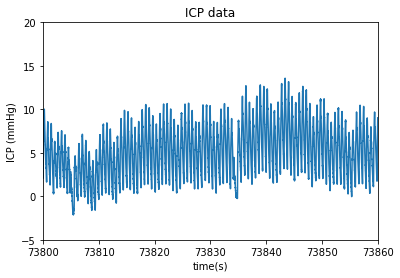

In [434]:
t1=720 #second
t2= 725 #second 
time=20.5 #hour
plt.figure()
plt.plot(ICP_time,ICP_signal)

plt.title('ICP data')
plt.ylabel('ICP (mmHg)')
plt.xlabel('time(s)')

plt.xlim([time*60*60,time*60*60+60])
plt.ylim([-5,20])

#### Spectral visualization

Text(0.5, 1.0, 'Colormap of ICP power in function of time and frequency')

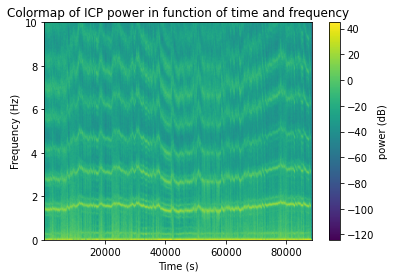

In [437]:
plt.specgram(ICP_signal,Fs=200, NFFT=6000, mode='psd')
plt.ylim([0,10])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='power (dB)')
plt.title('Colormap of ICP power in function of time and frequency')

### Time selection

In [438]:
#Time selection 
start=20.5*3600 #cond departure time 
duration=300 #second

indices=da.indexseq(start, duration, ICP_time)

### Mean ICP

In [439]:
np.mean(ICP_signal[indices])

5.418988774592506

### Heart rate determination

We calculate the heart rate by detemining the frequency peak in the periodogram between 1 and 2 Hz.

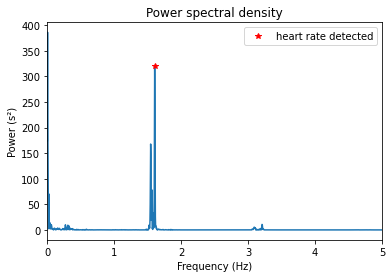

In [442]:
# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#Heart rate 
hr,index_hr=da.searchpeak(ICP_signal[indices],ICP_time[indices],fmin=1,fmax=2)

#visualisation
plt.plot(frequency, power)
plt.plot(hr,power[index_hr+1],'r*', label='heart rate detected')
plt.xlim([0,5])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (s²)')
plt.title('Power spectral density')
plt.legend()

In [443]:
print('Heart rate (Hz)',hr)

Heart rate (Hz) 1.6033066100632785


In [444]:
print(power[index_hr+1])

319.64754517884745


### Peak detection

We use peak and min detection functions to get values of the min and max of the ICP signal.

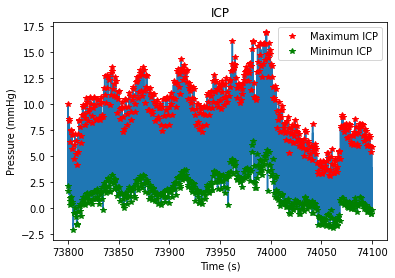

In [446]:
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#peak detection 
peaks_indices=signal.argrelextrema(ICP_signal[indices], np.greater, order=int(period_width/2)) 

#visualisation of the signal with peaks detected
plt.plot(ICP_time[indices],ICP_signal[indices])
plt.plot(ICP_time[indices][peaks_indices], ICP_signal[indices][peaks_indices], 'r*',label='Maximum ICP')

# min plot 
pmin,index_pmin=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)
plt.plot(ICP_time[indices][index_pmin],pmin, 'g*', label='Minimun ICP')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('ICP')
plt.legend()

#### Mean of systolic pressure of ICP signal

Let's calculate the mean of maximums found in the signal.

In [449]:
icp_max,pindex=ia.ICP_max(ICP_signal[indices],hr)

In [450]:
np.mean(icp_max)

9.452923805482921

#### Mean of diastolic pressure of ICP signal

Let's calculate the mean of minimums found in the signal.

In [451]:
icp_min=ia.ICP_min(ICP_time[indices],ICP_signal[indices],hr)

In [452]:
icp_min

1.400732686762503

### Amplitude of ICP signal

Let's calculate the amplitude of the signal.

In [453]:
# function to calculate the amplitude 

tampl=[] #amplitude time
ampl=[] # amplitude array
t_psys=ICP_time[indices][peaks_indices] # time of psys
t_pdia=ICP_time[indices][index_pmin] #time of pdia
psys=ICP_signal[indices][peaks_indices] #list of psys 
pdia=ICP_signal[indices][index_pmin] #list of pdia

for ti in t_psys :
    index_pdia=np.where((t_pdia>ti-1/hr) & (t_pdia<ti))
    index_psys=np.where(ti==t_psys)
    if(np.size(psys[index_psys]-pdia[index_pdia])>0):
        ampl.append(psys[index_psys][0]-pdia[index_pdia][0])
        tampl.append(t_pdia[index_pdia][0])


In [454]:
ampl

[6.51397705078125,
 5.703735351562497,
 6.392669677734378,
 6.472778320312499,
 5.055999755859378,
 6.78176879882812,
 6.575775146484372,
 6.481933593750003,
 5.992126464843753,
 5.69000244140625,
 6.96487426757812,
 7.436370849609378,
 8.175659179687498,
 7.381439208984378,
 6.031036376953128,
 7.695007324218753,
 8.546447753906254,
 9.152984619140623,
 8.7158203125,
 8.253479003906254,
 7.587432861328128,
 8.290100097656248,
 8.979034423828123,
 9.20562744140623,
 8.79135131835938,
 8.420562744140623,
 7.811737060546877,
 8.713531494140629,
 9.24911499023433,
 9.23767089843748,
 8.74786376953125,
 8.182525634765623,
 7.788848876953127,
 8.715820312499998,
 9.14154052734375,
 9.04769897460938,
 8.32901000976562,
 7.713317871093752,
 7.644653320312502,
 9.49401855468745,
 8.86917114257808,
 7.770538330078127,
 8.125305175781252,
 8.69979858398433,
 9.1873168945312,
 8.64028930664063,
 8.058929443359379,
 8.995056152343748,
 9.885406494140648,
 10.292816162109382,
 8.692932128906252,
 8

#### Visualization 
Let's plot the amplitude founded.

Text(0.5, 1.0, 'Visualisation of amplitude detected in dotted lines')

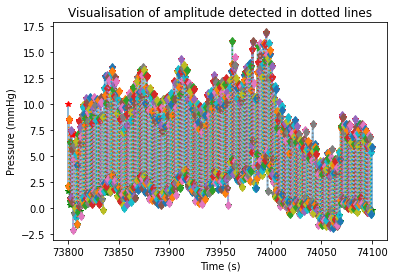

In [458]:
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#peak detection 
peaks_indices=signal.argrelextrema(ICP_signal[indices], np.greater, order=int(period_width/2)) 

#visualisation of the signal with peaks detected
plt.plot(ICP_time[indices],ICP_signal[indices],alpha=0.5)
plt.plot(ICP_time[indices][peaks_indices], ICP_signal[indices][peaks_indices], 'r*',label='Systolic pressure ICP')

# min plot 
pmin,index_pmin=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)
plt.plot(ICP_time[indices][index_pmin],pmin, 'g*', label='diastolic pressure ICP')

#amplitude plot 
ampl=[] # amplitude array
t_psys=ICP_time[indices][peaks_indices] # time of psys
t_pdia=ICP_time[indices][index_pmin] #time of pdia
psys=ICP_signal[indices][peaks_indices] #list of psys 
pdia=ICP_signal[indices][index_pmin] #list of pdia

for ti in t_psys :
    index_pdia=np.where((t_pdia>ti-1/hr) & (t_pdia<ti))
    index_psys=np.where(ti==t_psys)
    if(np.size(psys[index_psys]-pdia[index_pdia])>0):
        ampl.append(psys[index_psys][0]-pdia[index_pdia][0])
        plt.plot([t_psys[index_psys][0],t_pdia[index_pdia][0]],[psys[index_psys][0],pdia[index_pdia][0]],'d:')

plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('Visualisation of amplitude detected in dotted lines')

Let's try at another time. 

In [602]:
#Time selection 
start=74580 #cond departure time 
duration=300 #second

indices=da.indexseq(start, duration, ICP_time)

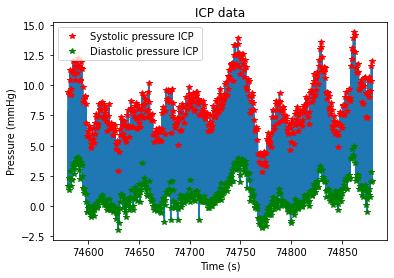

In [603]:
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#peak detection 
peaks_indices=signal.argrelextrema(ICP_signal[indices], np.greater, order=int(period_width/2)) 

#visualisation of the signal with peaks detected
plt.plot(ICP_time[indices],ICP_signal[indices])
plt.plot(ICP_time[indices][peaks_indices], ICP_signal[indices][peaks_indices], 'r*',label='Systolic pressure ICP')

# min plot 
pmin,index_pmin=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)
plt.plot(ICP_time[indices][index_pmin],pmin, 'g*', label='Diastolic pressure ICP')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('ICP data')
plt.legend()

Let's use the function amplitude_ICP in the library ICPanalysis

In [604]:
ampl,tampl,pdia_res=ia.amplitude_ICP(ICP_time[indices],ICP_signal[indices],peaks_indices,index_pmin,hr)

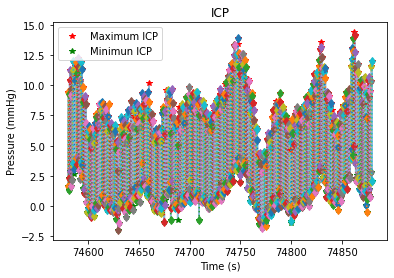

In [605]:
period_width=1/hr*fs

#visualisation of the signal with peaks detected
plt.plot(ICP_time[indices],ICP_signal[indices],alpha=0.5)
plt.plot(ICP_time[indices][peaks_indices], ICP_signal[indices][peaks_indices], 'r*',label='Maximum ICP')

# min plot 
plt.plot(ICP_time[indices][index_pmin],pmin, 'g*', label='Minimun ICP')

#amplitude plot 
amplitude=[] # amplitude array
t_psys=ICP_time[indices][peaks_indices] # time of psys
t_pdia=ICP_time[indices][index_pmin] #time of pdia
psys=ICP_signal[indices][peaks_indices] #list of psys 
pdia=ICP_signal[indices][index_pmin] #list of pdia

for ti in t_psys:
    index_pdia=np.where((t_pdia>ti-1/hr) & (t_pdia<ti))
    index_psys=np.where(ti==t_psys)
    if(np.size(psys[index_psys]-pdia[index_pdia])>0):
        amplitude.append(psys[index_psys][0]-pdia[index_pdia][0])
        plt.plot([t_psys[index_psys][0],t_pdia[index_pdia][0]],[psys[index_psys][0],pdia[index_pdia][0]],'d:')

plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('ICP')
plt.legend()
#plt.xlim([86540,86600])

This method seems to work well.

### Correction 

We will do a correction on the amplitude to correct outliers.

First, let's plot the amplitude during time.

Text(0.5, 1.0, 'Amplitude of ICP signal during time')

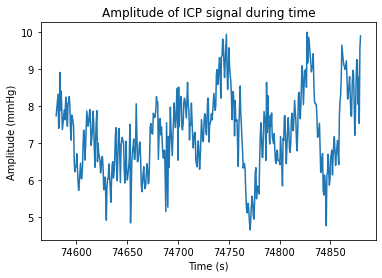

In [606]:
plt.plot(tampl,ampl)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mmHg)')
plt.title('Amplitude of ICP signal during time')

Let's correct our signal rejecting values higher than 2 standard deviation and we replace them by the median value.

In [607]:
ampl_corrected=ampl.copy()
ampl_corrected[np.abs(zscore(ampl)) > 2] = np.median(ampl)

#### Visulaization correction

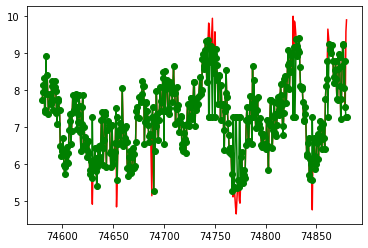

In [608]:
plt.plot(tampl,ampl,'r' ,label='amplitude')
plt.plot(tampl,ampl_corrected,'go-',label='amplitude corrected')

This correction method may be ineffective we could try later a method using the derivative.

### Scatter plot 

Let's plot the amplitude as a function of the diastolic pressure.

First we plot the linear regression on a window of five minutes.

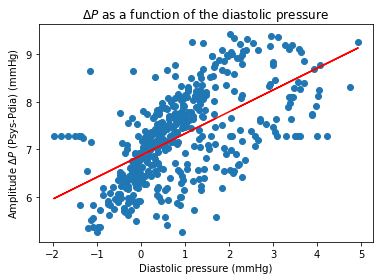

In [609]:
#indi=da.indexseq(86560,60, ICP_time)

    
    # ICP features
    # periodogram 
frequency_icp,power_icp=signal.periodogram(ICP_signal[indi],fs,window='hanning',nfft=None ,scaling='density')
    #Heart rate 
hr_icp,index_hr=da.searchpeak(ICP_signal[indi],ICP_time[indi],fmin=0.8,fmax=2)
power_hr=power_icp[index_hr+1]*1e6
mean_ICP=np.mean(ICP_signal[indi])
icp_max,psysindex=ia.ICP_max(ICP_signal[indi],hr_icp)
icp_min,pdiaindex=ia.detect_min(ICP_time[indi],ICP_signal[indi],hr_icp)
ampli,tamp,pdiast=ia.amplitude_ICP(ICP_time[indi], ICP_signal[indi], psysindex, pdiaindex, hr_icp)
#amplitude correction 
a_corrected=ampli.copy()
a_corrected[np.abs(zscore(ampli)) > 2] = np.median(ampli)
# this correction method may be ineffective we could try later a method using the derivative


# plot
plt.scatter(pdia_res, ampl_corrected, label='scatter points')
plt.xlabel('Diastolic pressure (mmHg)')
plt.ylabel('Amplitude $\Delta P$ (Psys-Pdia) (mmHg)')
plt.title('$\Delta P$ as a function of the diastolic pressure')

# fit linear regression 
slope,intercept, rvalue, pvalue,stderr = stats.linregress(pdia_res, ampl_corrected)
#plot linear fit
plt.plot(pdia_res,slope*pdia_res+intercept, 'r', label='linear regression fitted')

# erreur moyenne relative :
ypred=slope*pdia_res+intercept
ydata=ampl_corrected
err=1/len(pdia_res)*sum(abs(ypred-ydata)/ydata)

In [610]:
slope

0.4584884758978022

In [611]:
err

0.08777647089986773

In [612]:
stderr

0.029294799278396726

In [613]:
pvalue

2.4403849297048234e-44

It can be noticed that in a 5-minute window there are several different regimes. So we plot here on the same graph 5 slopes founded in 5 windows of 60 seconds.

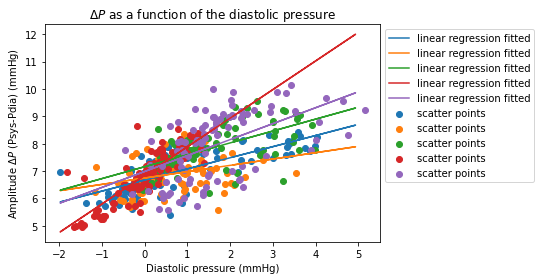

In [614]:
ti=start
end=start+300
while ti<end :    
    indi=da.indexseq(ti,60, ICP_time)

    # ICP features
    # periodogram 
    frequency_icp,power_icp=signal.periodogram(ICP_signal[indi],fs,window='hanning',nfft=None ,scaling='density')
    #Heart rate 
    hr_icp,index_hr=da.searchpeak(ICP_signal[indi],ICP_time[indi],fmin=0.8,fmax=2)
    power_hr=power_icp[index_hr+1]*1e6
    mean_ICP=np.mean(ICP_signal[indi])
    icp_max,psysindex=ia.ICP_max(ICP_signal[indi],hr_icp)
    icp_min,pdiaindex=ia.detect_min(ICP_time[indi],ICP_signal[indi],hr_icp)
    ampli,tamp,pdiast=ia.amplitude_ICP(ICP_time[indi], ICP_signal[indi], psysindex, pdiaindex, hr_icp)
    #amplitude correction 
    a_corrected=ampli.copy()
    a_corrected[np.abs(zscore(ampli)) > 2] = np.median(ampli)

    # plot
    plt.scatter(pdiast, a_corrected, label='scatter points')
    plt.xlabel('Diastolic pressure (mmHg)')
    plt.ylabel('Amplitude $\Delta P$ (Psys-Pdia) (mmHg)')
    plt.title('$\Delta P$ as a function of the diastolic pressure')
    # fit linear regression 
    slope,intercept, rvalue, pvalue,stderr = stats.linregress(pdiast, a_corrected)
    #plot linear fit
    plt.plot(pdia_res,slope*pdia_res+intercept, label='linear regression fitted')
    plt.legend(bbox_to_anchor=(1, 1))
    ti=ti+60

# Respiratory frequency 

We want to determine the respiratory frequency of the patient. We will try to find it in periodograms of the amplitude and the diastolic pressure on different time windows and determine then which method is the most effective to detect it. 

## Spectrograms

### Amplitude

##### 30 sec

Text(0, 0.5, 'Amplitude (mmHg)')

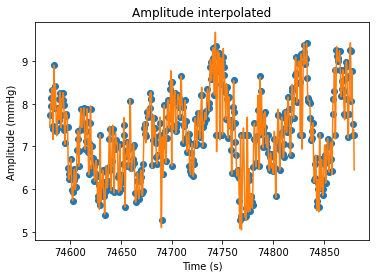

In [618]:
# interpolation 
from scipy.interpolate import InterpolatedUnivariateSpline

# time vector creation 
spantime=dg.generate_time(300,10,start=74580)

# interpolation 
ampl_interpolated=InterpolatedUnivariateSpline(tampl,ampl_corrected)

#plot 
plt.figure()
plt.plot(tampl, ampl_corrected, 'o')
plt.plot(spantime,ampl_interpolated(spantime))
plt.title('Amplitude interpolated')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mmHg)')

(0.0, 20.0)

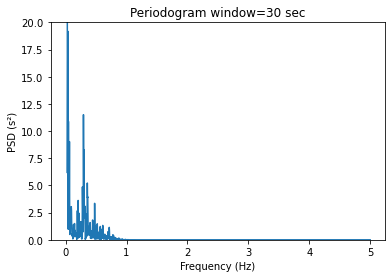

In [619]:
freqf,powerf=da.periodogram(ampl_interpolated(spantime),spantime)
plt.plot(freqf,powerf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.title('Periodogram window=30 sec')
plt.ylim([0,20])

(0.0, 5.0)

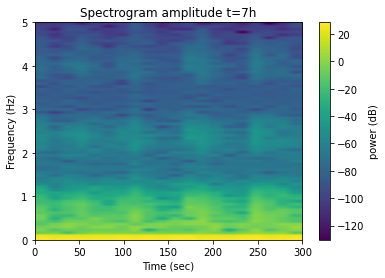

In [620]:
plt.figure()
plt.specgram(ampl_interpolated(spantime),NFFT=150,noverlap=0,Fs=10)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.colorbar(label='power (dB)')
plt.title('Spectrogram amplitude t=7h')
plt.ylim([0,5])

Text(0, 0.5, 'Amplitude (mmHg)')

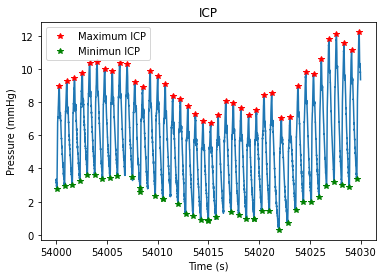

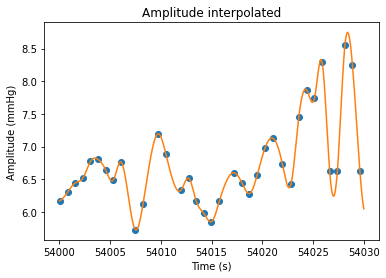

In [621]:
start=15*3600 #cond departure time 
duration=30 #second

indices=da.indexseq(start, duration, ICP_time)
hr,index_hr=da.searchpeak(ICP_signal[indices],ICP_time[indices],fmin=1,fmax=2)
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#peak detection 
peaks_indices=signal.argrelextrema(ICP_signal[indices], np.greater, order=int(period_width/2)) 

#visualisation of the signal with peaks detected
plt.plot(ICP_time[indices],ICP_signal[indices])
plt.plot(ICP_time[indices][peaks_indices], ICP_signal[indices][peaks_indices], 'r*',label='Maximum ICP')

# min plot 
pmin,index_pmin=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)
plt.plot(ICP_time[indices][index_pmin],pmin, 'g*', label='Minimun ICP')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('ICP')
plt.legend()

#amplitude
ampl,tampl,pdia_res=ia.amplitude_ICP(ICP_time[indices],ICP_signal[indices],peaks_indices,index_pmin,hr)

#correction 
ampl_corrected=ampl.copy()
ampl_corrected[np.abs(zscore(ampl)) > 2] = np.median(ampl)

# time vector creation 
spantime=dg.generate_time(duration,10,start)

# interpolation 
ampl_interpolated=InterpolatedUnivariateSpline(tampl,ampl_corrected)

#plot 
plt.figure()
plt.plot(tampl, ampl_corrected, 'o')
plt.plot(spantime,ampl_interpolated(spantime))
plt.title('Amplitude interpolated')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mmHg)')

(0.0, 20.0)

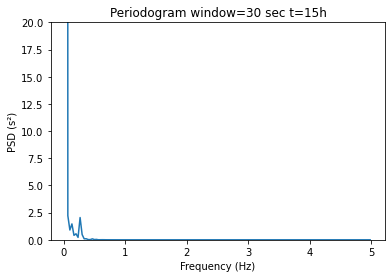

In [622]:
freqf,powerf=da.periodogram(ampl_interpolated(spantime),spantime)
plt.plot(freqf,powerf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.title('Periodogram window=30 sec t=15h')
plt.ylim([0,20])

(0.0, 5.0)

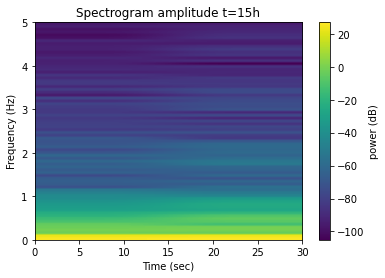

In [623]:
plt.figure()
plt.specgram(ampl_interpolated(spantime),NFFT=150,noverlap=0,Fs=10)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.colorbar(label='power (dB)')
plt.title('Spectrogram amplitude t=15h')
plt.ylim([0,5])

#### 1 min

Text(0, 0.5, 'Amplitude (mmHg)')

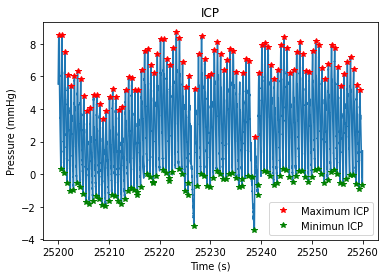

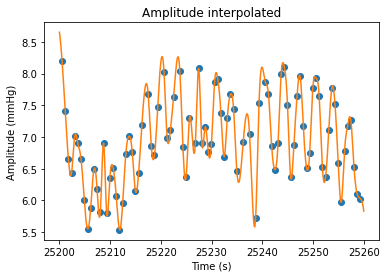

In [624]:
from scipy.interpolate import InterpolatedUnivariateSpline

start=7*3600 #cond departure time 
duration=60 #second

indices=da.indexseq(start, duration, ICP_time)
hr,index_hr=da.searchpeak(ICP_signal[indices],ICP_time[indices],fmin=1,fmax=2)
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#peak detection 
peaks_indices=signal.argrelextrema(ICP_signal[indices], np.greater, order=int(period_width/2)) 

#visualisation of the signal with peaks detected
plt.plot(ICP_time[indices],ICP_signal[indices])
plt.plot(ICP_time[indices][peaks_indices], ICP_signal[indices][peaks_indices], 'r*',label='Maximum ICP')

# min plot 
pmin,index_pmin=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)
plt.plot(ICP_time[indices][index_pmin],pmin, 'g*', label='Minimun ICP')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('ICP')
plt.legend()

#amplitude
ampl,tampl,pdia_res=ia.amplitude_ICP(ICP_time[indices],ICP_signal[indices],peaks_indices,index_pmin,hr)

#correction 
ampl_corrected=ampl.copy()
ampl_corrected[np.abs(zscore(ampl)) > 2] = np.median(ampl)

# time vector creation 
spantime=dg.generate_time(duration,10,start)

# interpolation 
ampl_interpolated=InterpolatedUnivariateSpline(tampl,ampl_corrected)

#plot 
plt.figure()
plt.plot(tampl, ampl_corrected, 'o')
plt.plot(spantime,ampl_interpolated(spantime))
plt.title('Amplitude interpolated')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mmHg)')

(0.0, 20.0)

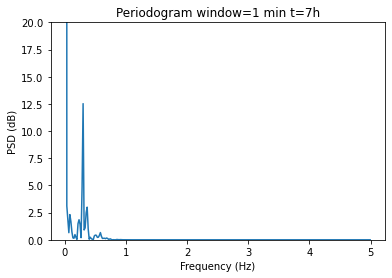

In [625]:
freqf,powerf=da.periodogram(ampl_interpolated(spantime),spantime)
plt.plot(freqf,powerf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')
plt.title('Periodogram window=1 min t=7h')
plt.ylim([0,20])

(0.0, 5.0)

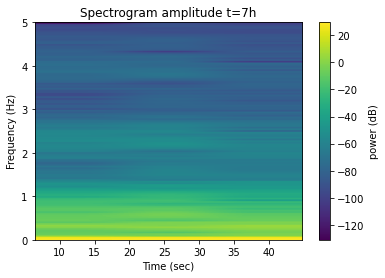

In [626]:
plt.figure()
plt.specgram(ampl_interpolated(spantime),NFFT=256,Fs=10)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.colorbar(label='power (dB)')
plt.title('Spectrogram amplitude t=7h')
plt.ylim([0,5])

Text(0, 0.5, 'Amplitude (mmHg)')

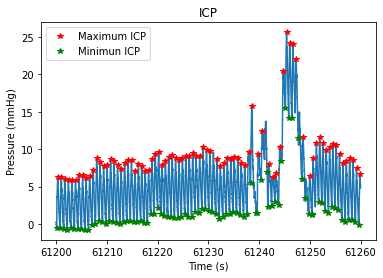

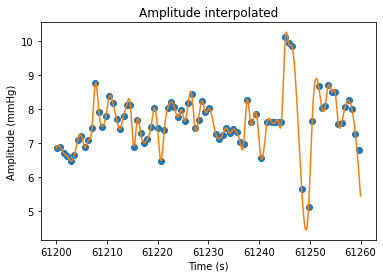

In [673]:
start=17*3600 #cond departure time 
duration=60 #second

indices=da.indexseq(start, duration, ICP_time)
hr,index_hr=da.searchpeak(ICP_signal[indices],ICP_time[indices],fmin=1,fmax=2)
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#peak detection 
peaks_indices=signal.argrelextrema(ICP_signal[indices], np.greater, order=int(period_width/2)) 

#visualisation of the signal with peaks detected
plt.plot(ICP_time[indices],ICP_signal[indices])
plt.plot(ICP_time[indices][peaks_indices], ICP_signal[indices][peaks_indices], 'r*',label='Maximum ICP')

# min plot 
pmin,index_pmin=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)
plt.plot(ICP_time[indices][index_pmin],pmin, 'g*', label='Minimun ICP')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('ICP')
plt.legend()

#amplitude
ampl,tampl,pdia_res=ia.amplitude_ICP(ICP_time[indices],ICP_signal[indices],peaks_indices,index_pmin,hr)

#correction 
ampl_corrected=ampl.copy()
ampl_corrected[np.abs(zscore(ampl)) > 2] = np.median(ampl)

# time vector creation 
spantime=dg.generate_time(duration,10,start)

# interpolation 
idx=np.where(np.diff(tampl)>0.0)[0]
ampl_interpolated=InterpolatedUnivariateSpline(tampl[idx],ampl_corrected[idx])

#plot 
plt.figure()
plt.plot(tampl, ampl_corrected, 'o')
plt.plot(spantime,ampl_interpolated(spantime))
plt.title('Amplitude interpolated')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mmHg)')

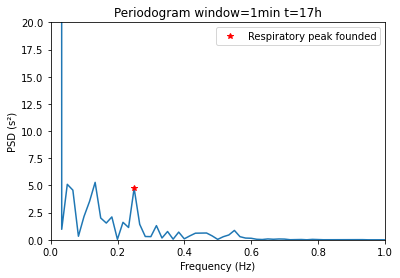

In [674]:
freqf,powerf=da.periodogram(ampl_interpolated(spantime),spantime)
plt.plot(freqf,powerf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.title('Periodogram window=1min t=17h')
plt.ylim([0,20])
plt.xlim([0,1])

#respiratory frequency 
resp,index_resp=da.searchpeak(ampl_interpolated(spantime),spantime,fmin=0.16,fmax=0.8)
plt.plot(resp,powerf[index_resp],'r*',label='Respiratory peak founded')
plt.legend()

(0.0, 5.0)

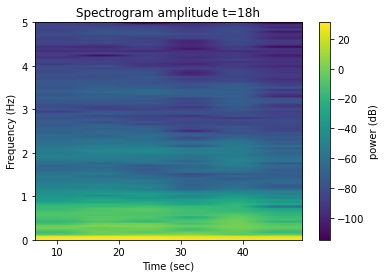

In [629]:
plt.figure()
plt.specgram(ampl_interpolated(spantime),NFFT=200,Fs=10)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.colorbar(label='power (dB)')
plt.title('Spectrogram amplitude t=18h')
plt.ylim([0,5])

#### 5 min

In [670]:
start=18*3600 #cond departure time 
duration=300 #second

indices=da.indexseq(start, duration, ICP_time)
hr,index_hr=da.searchpeak(ICP_signal[indices],ICP_time[indices],fmin=1,fmax=2)
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#peak detection 
peaks_indices=signal.argrelextrema(ICP_signal[indices], np.greater, order=int(period_width/2)) 

# min plot 
pmin,index_pmin=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)

#amplitude
ampl,tampl,pdia_res=ia.amplitude_ICP(ICP_time[indices],ICP_signal[indices],peaks_indices,index_pmin,hr)

#correction 
ampl_corrected=ampl.copy()
ampl_corrected[np.abs(zscore(ampl)) > 2] = np.median(ampl)

# time vector creation 
spantime=dg.generate_time(duration,10,start)

# interpolation 
idx=np.where(np.diff(tampl)>0.0)[0]
ampl_interpolated=InterpolatedUnivariateSpline(tampl[idx],ampl_corrected[idx])

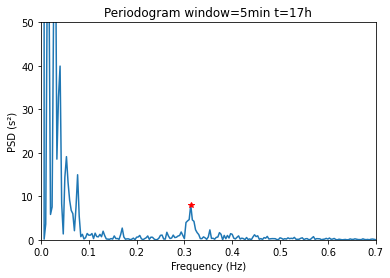

In [671]:
freqf,powerf=da.periodogram(ampl_interpolated(spantime),spantime)
plt.plot(freqf,powerf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.title('Periodogram window=5min t=17h')
plt.ylim([0,50])
plt.xlim([0,0.7])

#respiratory frequency 
resp,index_resp=da.searchpeak(ampl_interpolated(spantime),spantime,fmin=0.16,fmax=0.8)
plt.plot(resp,powerf[index_resp],'r*',label='Respiratory peak founded')

In [524]:
resp

0.25991336221637806

(0.0, 5.0)

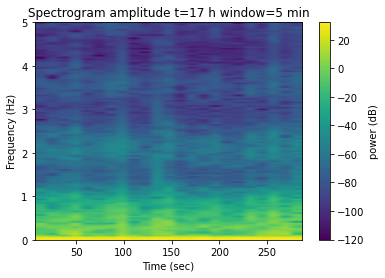

In [632]:
plt.figure()
plt.specgram(ampl_interpolated(spantime),NFFT=250,Fs=10)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.colorbar(label='power (dB)')
plt.title('Spectrogram amplitude t=17 h window=5 min')
plt.ylim([0,5])

In [633]:
def respiratory_frequency(time, amplitude):
    """
    Return the mean of respiratory frequencies founded in 1 minute size window.

    Parameters
    ----------
    time : np.array
        time vector.
    amplitude : np.array
        amplitude vector.

    Returns
    -------
    fresp : float
        respiratory frequency.

    """
    resp_list=[]
    ti=time[0]
    cmp=0
    while ti<time[len(time)-1]-60 :
        indices=da.indexseq(ti, 60, time)
    
        # time vector creation 
        spantime=dg.generate_time(60,10,ti)

        # interpolation 
        idx=np.where(np.diff(time[indices])>0.0)[0]
        ampl_interpolated=InterpolatedUnivariateSpline(time[indices][idx],amplitude[indices][idx])
        #respiratory frequency 
        resp,index_resp=da.searchpeak(ampl_interpolated(spantime),spantime,fmin=0.16,fmax=0.8)
        resp_list.append(resp)
        ti=ti+60
        cmp=cmp+1
    return np.mean(resp_list)

In [634]:
resi=respiratory_frequency(tampl, ampl_corrected)

In [635]:
resi

0.25374376040302693

#### 10 min 

In [646]:
start=7*3600 #cond departure time 
duration=600 #second

indices=da.indexseq(start, duration, ICP_time)
hr,index_hr=da.searchpeak(ICP_signal[indices],ICP_time[indices],fmin=1,fmax=2)
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density')

#peak detection 
peaks_indices=signal.argrelextrema(ICP_signal[indices], np.greater, order=int(period_width/2)) 

# min plot 
pmin,index_pmin=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)

#amplitude
ampl,tampl,pdia_res=ia.amplitude_ICP(ICP_time[indices],ICP_signal[indices],peaks_indices,index_pmin,hr)

#correction 
ampl_corrected=ampl.copy()
ampl_corrected[np.abs(zscore(ampl)) > 2] = np.median(ampl)

# time vector creation 
spantime=dg.generate_time(duration,10,start)

# interpolation 
ampl_interpolated=InterpolatedUnivariateSpline(tampl,ampl_corrected)

(0.0, 50.0)

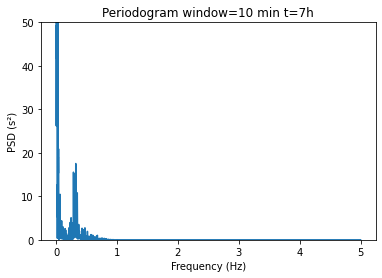

In [647]:
freqf,powerf=da.periodogram(ampl_interpolated(spantime),spantime)
plt.plot(freqf,powerf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.title('Periodogram window=10 min t=7h')
plt.ylim([0,50])

(0.0, 5.0)

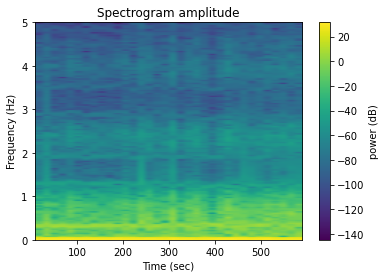

In [648]:
plt.figure()
plt.specgram(ampl_interpolated(spantime),NFFT=300,Fs=10)
plt.colorbar(label='power (dB)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.title('Spectrogram amplitude')

plt.ylim([0,5])

### Diastolic pressure

#### 30 sec

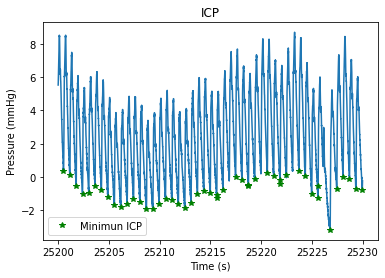

In [649]:
start=7*3600 #cond departure time 
duration=30 #second

indices=da.indexseq(start, duration, ICP_time)
hr,index_hr=da.searchpeak(ICP_signal[indices],ICP_time[indices],fmin=1,fmax=2)
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density') 

# min plot 
pdia,index_pdia=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)

# min plot 
plt.plot(ICP_time[indices],ICP_signal[indices])
plt.plot(ICP_time[indices][index_pdia],pdia, 'g*', label='Minimun ICP')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('ICP')
plt.legend()


Text(0, 0.5, 'Amplitude (mmHg)')

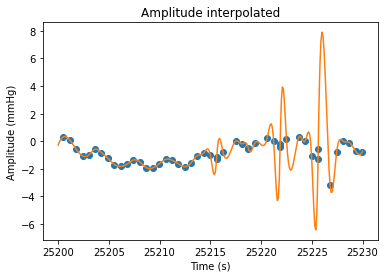

In [650]:
# time vector creation 
spantime=dg.generate_time(duration,10,start)

# interpolation 
pdia_interpolated=InterpolatedUnivariateSpline(ICP_time[indices][index_pdia],pdia)

#plot 
plt.figure()
plt.plot(ICP_time[indices][index_pdia], pdia, 'o')
plt.plot(spantime,pdia_interpolated(spantime))
plt.title('Amplitude interpolated')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mmHg)')

(0.0, 1.0)

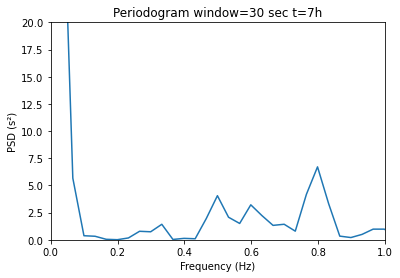

In [651]:
freqf,powerf=da.periodogram(pdia_interpolated(spantime),spantime)
plt.plot(freqf,powerf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.title('Periodogram window=30 sec t=7h')
plt.ylim([0,20])
plt.xlim([0,1])

(0.0, 5.0)

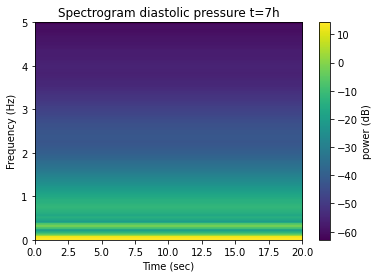

In [652]:
plt.figure()
plt.specgram(pdia_interpolated(spantime),NFFT=200,noverlap=0,Fs=10, mode='psd')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.colorbar(label='power (dB)')
plt.title('Spectrogram diastolic pressure t=7h')
plt.ylim([0,5])

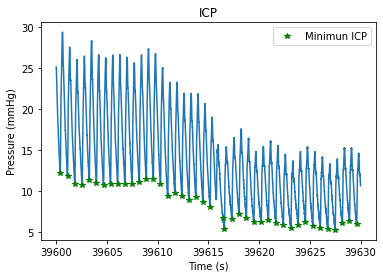

In [653]:
start=11*3600 #cond departure time 
duration=30 #second

indices=da.indexseq(start, duration, ICP_time)
hr,index_hr=da.searchpeak(ICP_signal[indices],ICP_time[indices],fmin=1,fmax=2)
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density') 

# min plot 
pdia,index_pdia=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)

# min plot 
plt.plot(ICP_time[indices],ICP_signal[indices])
plt.plot(ICP_time[indices][index_pdia],pdia, 'g*', label='Minimun ICP')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('ICP')
plt.legend()

Text(0, 0.5, 'Amplitude (mmHg)')

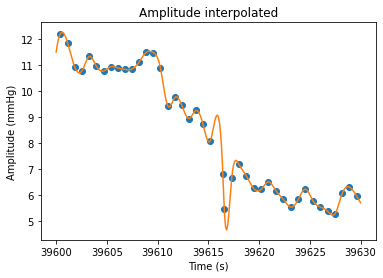

In [654]:
# time vector creation 
spantime=dg.generate_time(duration,10,start)

# interpolation 
pdia_interpolated=InterpolatedUnivariateSpline(ICP_time[indices][index_pdia],pdia)

#plot 
plt.figure()
plt.plot(ICP_time[indices][index_pdia], pdia, 'o')
plt.plot(spantime,pdia_interpolated(spantime))
plt.title('Amplitude interpolated')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mmHg)')

(0.0, 20.0)

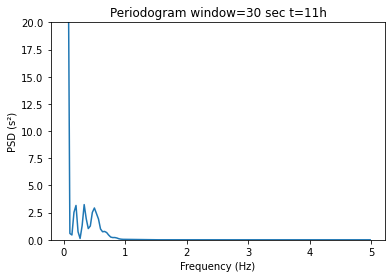

In [655]:
freqf,powerf=da.periodogram(pdia_interpolated(spantime),spantime)
plt.plot(freqf,powerf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.title('Periodogram window=30 sec t=11h')
plt.ylim([0,20])

(0.0, 5.0)

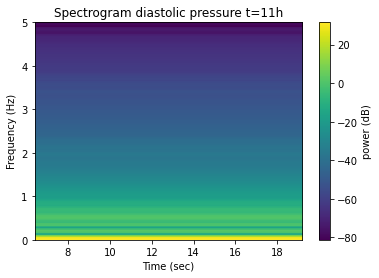

In [656]:
plt.figure()
plt.specgram(pdia_interpolated(spantime),NFFT=256,Fs=10, mode='psd')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.colorbar(label='power (dB)')
plt.title('Spectrogram diastolic pressure t=11h')
plt.ylim([0,5])

#### 1 min

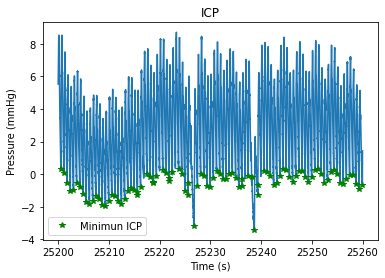

In [657]:
start=7*3600 #cond departure time 
duration=60 #second

indices=da.indexseq(start, duration, ICP_time)
hr,index_hr=da.searchpeak(ICP_signal[indices],ICP_time[indices],fmin=1,fmax=2)
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density') 

# min plot 
pdia,index_pdia=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)

# min plot 
plt.plot(ICP_time[indices],ICP_signal[indices])
plt.plot(ICP_time[indices][index_pdia],pdia, 'g*', label='Minimun ICP')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('ICP')
plt.legend()

Text(0, 0.5, 'Amplitude (mmHg)')

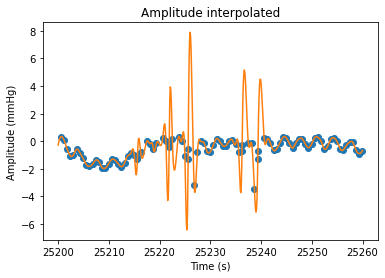

In [658]:
# time vector creation 
spantime=dg.generate_time(duration,10,start)

# interpolation 
pdia_interpolated=InterpolatedUnivariateSpline(ICP_time[indices][index_pdia],pdia)

#plot 
plt.figure()
plt.plot(ICP_time[indices][index_pdia], pdia, 'o')
plt.plot(spantime,pdia_interpolated(spantime))
plt.title('Amplitude interpolated')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mmHg)')

(0.0, 50.0)

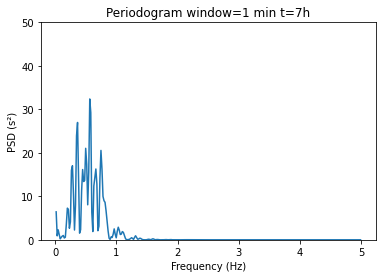

In [659]:
freqf,powerf=da.periodogram(pdia_interpolated(spantime),spantime)
plt.plot(freqf,powerf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.title('Periodogram window=1 min t=7h')
plt.ylim([0,50])

(0.0, 5.0)

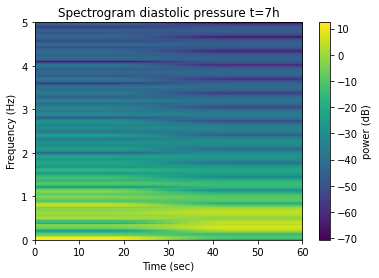

In [661]:
plt.figure()
plt.specgram(pdia_interpolated(spantime),NFFT=300,noverlap=0,Fs=10, mode='psd')
plt.colorbar(label='power (dB)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.title('Spectrogram diastolic pressure t=7h')
plt.ylim([0,5])

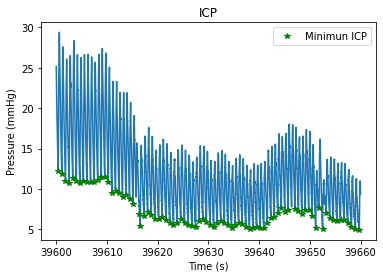

In [662]:
start=11*3600 #cond departure time 
duration=60 #second

indices=da.indexseq(start, duration, ICP_time)
hr,index_hr=da.searchpeak(ICP_signal[indices],ICP_time[indices],fmin=1,fmax=2)
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density') 

# min plot 
pdia,index_pdia=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)

# min plot 
plt.plot(ICP_time[indices],ICP_signal[indices])
plt.plot(ICP_time[indices][index_pdia],pdia, 'g*', label='Minimun ICP')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('ICP')
plt.legend()

Text(0, 0.5, 'Amplitude (mmHg)')

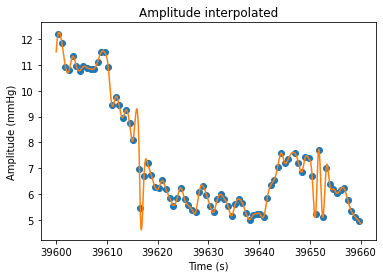

In [663]:
# time vector creation 
spantime=dg.generate_time(duration,10,start)

# interpolation 
pdia_interpolated=InterpolatedUnivariateSpline(ICP_time[indices][index_pdia],pdia)

#plot 
plt.figure()
plt.plot(ICP_time[indices][index_pdia], pdia, 'o')
plt.plot(spantime,pdia_interpolated(spantime))
plt.title('Amplitude interpolated')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mmHg)')

(0.0, 10.0)

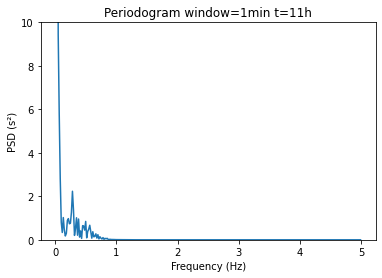

In [664]:
freqf,powerf=da.periodogram(pdia_interpolated(spantime),spantime)
plt.plot(freqf,powerf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.title('Periodogram window=1min t=11h')
plt.ylim([0,10])

(0.0, 5.0)

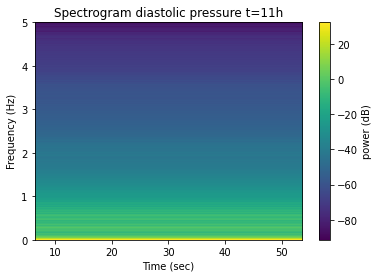

In [665]:
plt.figure()
plt.specgram(pdia_interpolated(spantime),NFFT=600,Fs=10, mode='psd')
plt.colorbar(label='power (dB)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.title('Spectrogram diastolic pressure t=11h')
plt.ylim([0,5])

#### 5 min

(0.0, 5.0)

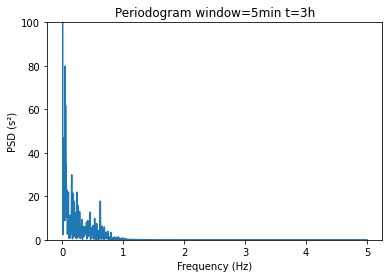

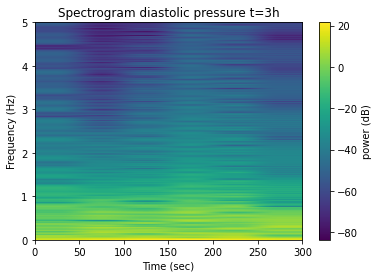

In [667]:
start=3*3600 #cond departure time 
duration=300 #second

indices=da.indexseq(start, duration, ICP_time)
hr,index_hr=da.searchpeak(ICP_signal[indices],ICP_time[indices],fmin=1,fmax=2)
## expected width of peaks : 
period_width=1/hr*fs

# periodogram 
frequency,power=signal.periodogram(ICP_signal[indices],fs,window='hanning',nfft=None ,scaling='density') 

# min plot 
pdia,index_pdia=ia.detect_min(ICP_time[indices],ICP_signal[indices],hr)

# time vector creation 
spantime=dg.generate_time(duration,10,start)

# interpolation 
pdia_interpolated=InterpolatedUnivariateSpline(ICP_time[indices][index_pdia],pdia)

freqf,powerf=da.periodogram(pdia_interpolated(spantime),spantime)
plt.plot(freqf,powerf)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (s²)')
plt.title('Periodogram window=5min t=3h')
plt.ylim([0,100])

plt.figure()
plt.specgram(pdia_interpolated(spantime),NFFT=500,noverlap=0,Fs=10, mode='psd')
plt.colorbar(label='power (dB)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.title('Spectrogram diastolic pressure t=3h')
plt.ylim([0,5])

The most effective technique to detect the peak of respiratory frequency is in the periodogram of the amplitude on windows of 1 minute.